# Principal Component Analysis (PCA)

This notebook covers the fundamentals of Principal Component Analysis (PCA), a dimensionality reduction technique widely used in machine learning and data science.

### Learning Objectives
- Understand what PCA is and why it's useful
- Learn the mathematical intuition behind PCA
- Implement PCA using scikit-learn
- Visualize and interpret PCA results
- Apply PCA to a real dataset

## 1. Introduction to PCA

### What is PCA?
Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space while preserving as much variance as possible.

### Why use PCA?
- **Dimensionality reduction**: Simplify data with many features
- **Visualization**: Project high-dimensional data to 2D or 3D for visualization
- **Noise reduction**: By keeping only principal components with high variance
- **Feature extraction**: Create uncorrelated features from correlated ones
- **Data preprocessing**: Before applying machine learning algorithms

## 2. Mathematical Intuition

### Key Concepts:
1. **Variance**: PCA seeks directions (principal components) with maximum variance
2. **Covariance Matrix**: Describes how features vary together
3. **Eigenvectors & Eigenvalues**: Eigenvectors of the covariance matrix are the principal components, and eigenvalues represent the amount of variance captured

### Basic Steps of PCA:
1. Standardize the data (zero mean, unit variance)
2. Compute the covariance matrix
3. Compute eigenvectors and eigenvalues of the covariance matrix
4. Sort eigenvectors by eigenvalues in descending order
5. Select top k eigenvectors to form a projection matrix
6. Transform the original data using the projection matrix

Let's see a simple visualization of PCA:

In [25]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

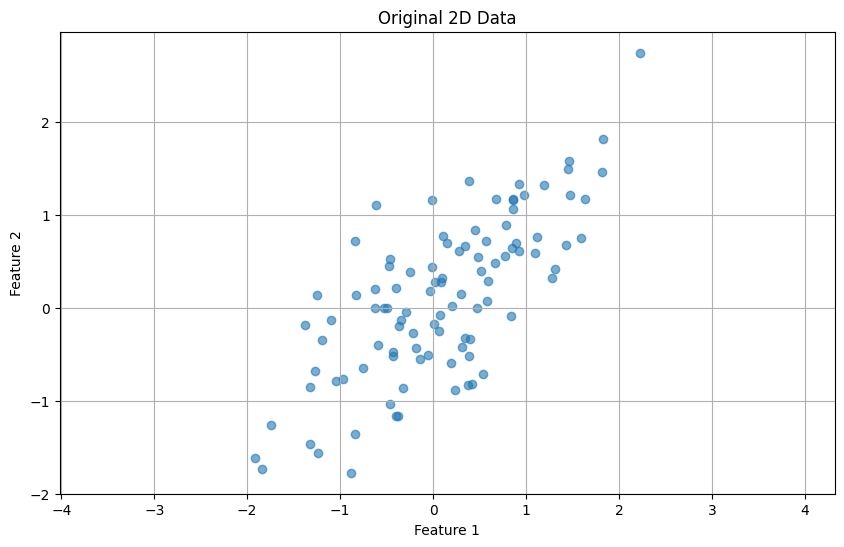

In [26]:
# Create a simple 2D dataset with correlation
n_samples = 100
mean = [0, 0]
cov = [[1, 0.8], [0.8, 1]]  # Correlated data

X = np.random.multivariate_normal(mean, cov, n_samples)

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
plt.title('Original 2D Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis('equal')
plt.grid(True)
plt.show()

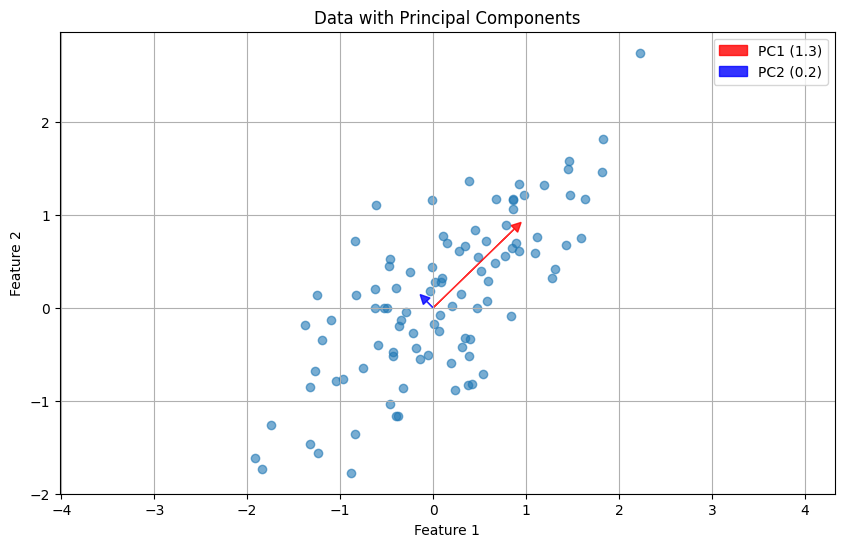

In [29]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the data with principal components
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)

# Plot the principal components with different colors
colors = ['r', 'b']  # Define different colors for each principal component
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # Scale by variance explained
    plt.arrow(0, 0, comp[0], comp[1], color=colors[i], alpha=0.8, 
              head_width=0.1, head_length=0.1, length_includes_head=True,
              label=f'PC{i+1} ({var:.1f})')

plt.title('Data with Principal Components')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

### Explained Variance
A key concept in PCA is explained variance, which tells us how much information (variance) is captured by each principal component.

Explained variance ratio: [0.86883395 0.13116605]
Cumulative explained variance: [0.86883395 1.        ]


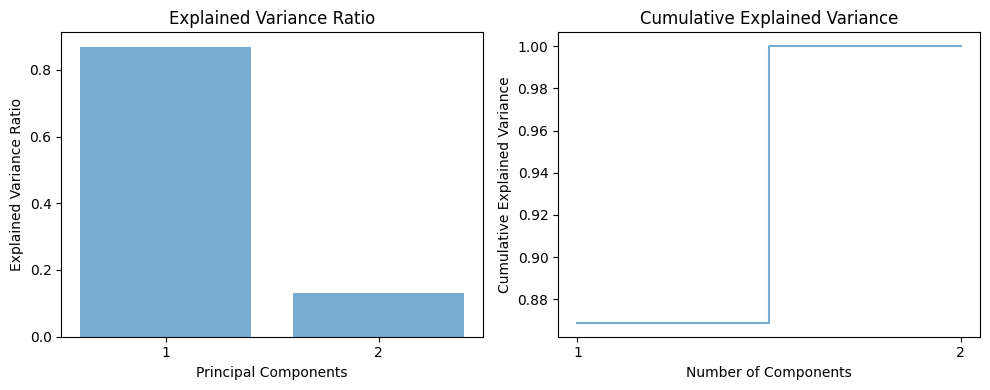

In [30]:
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}")

# Plot explained variance
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, 3), pca.explained_variance_ratio_, alpha=0.6)
plt.title('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks([1, 2])

plt.subplot(1, 2, 2)
plt.step(range(1, 3), np.cumsum(pca.explained_variance_ratio_), alpha=0.6, where='mid')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks([1, 2])
plt.tight_layout()
plt.show()

## 3. Implementing PCA with scikit-learn

Let's apply PCA to a more realistic dataset. We'll use the Iris dataset, which has 4 features.

In [31]:
from sklearn.datasets import load_iris

# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

# Convert to pandas DataFrame for easier handling
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['species'] = df['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Display the first few rows
print("Dataset shape:", X.shape)
df.head()

Dataset shape: (150, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


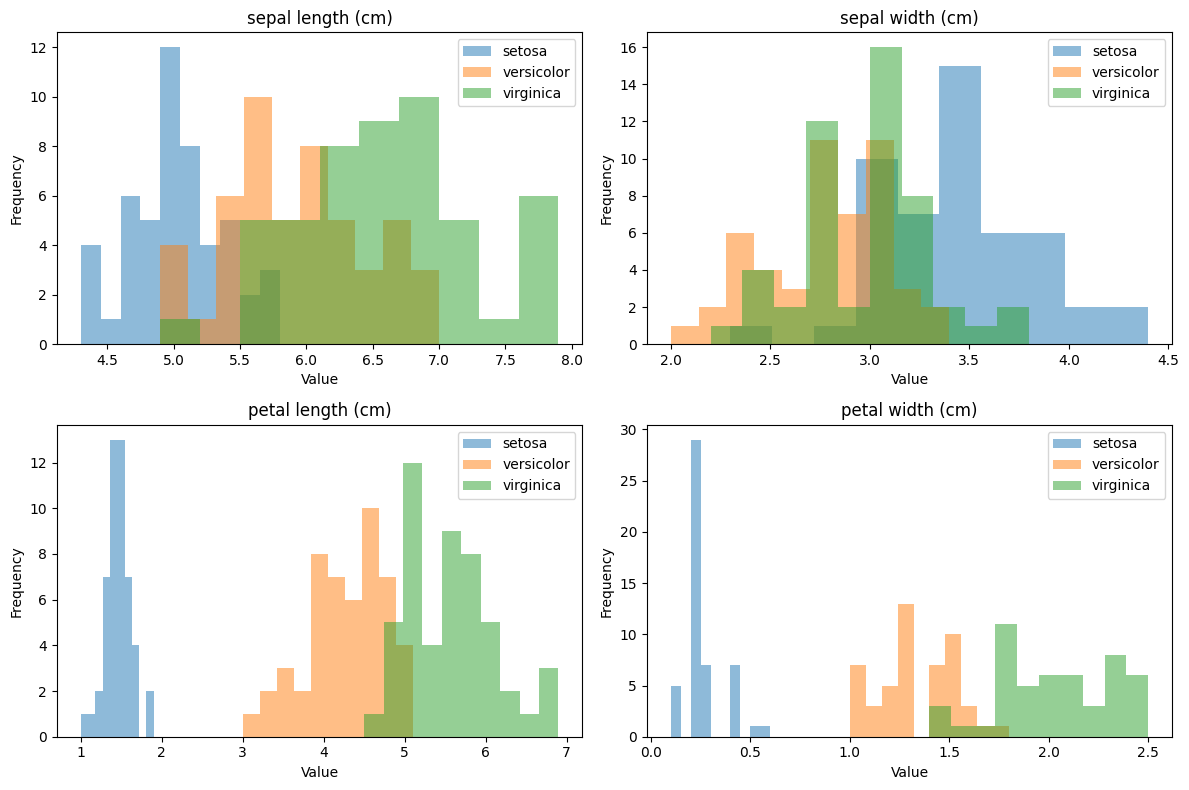

In [32]:
# Visualize feature distributions
plt.figure(figsize=(12, 8))
for i, feature in enumerate(feature_names):
    plt.subplot(2, 2, i+1)
    for species in df['species'].unique():
        subset = df[df['species'] == species]
        plt.hist(subset[feature], alpha=0.5, label=species)
    plt.title(feature)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()

In [33]:
# Standardize the data
X_std = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_std)

# Examine explained variance
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)
print("Cumulative explained variance:", np.cumsum(explained_variance))

Explained variance ratio: [0.72962445 0.22850762 0.03668922 0.00517871]
Cumulative explained variance: [0.72962445 0.95813207 0.99482129 1.        ]


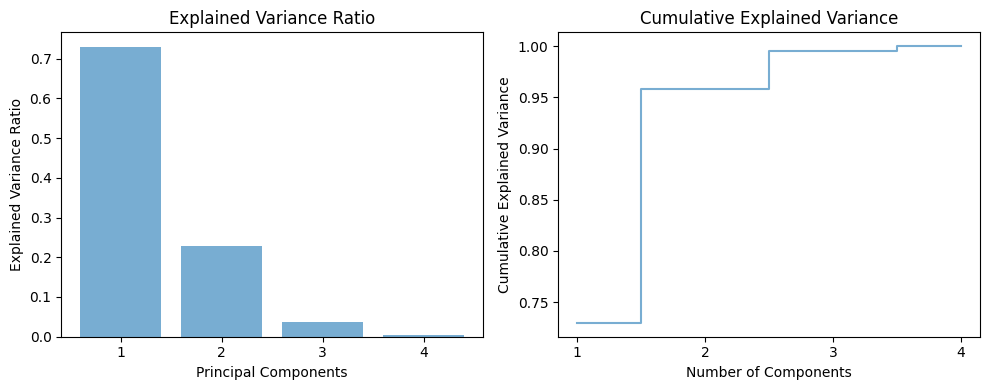

In [34]:
# Plot explained variance
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, 5), explained_variance, alpha=0.6)
plt.title('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, 5))

plt.subplot(1, 2, 2)
plt.step(range(1, 5), np.cumsum(explained_variance), alpha=0.6, where='mid')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, 5))
plt.tight_layout()
plt.show()

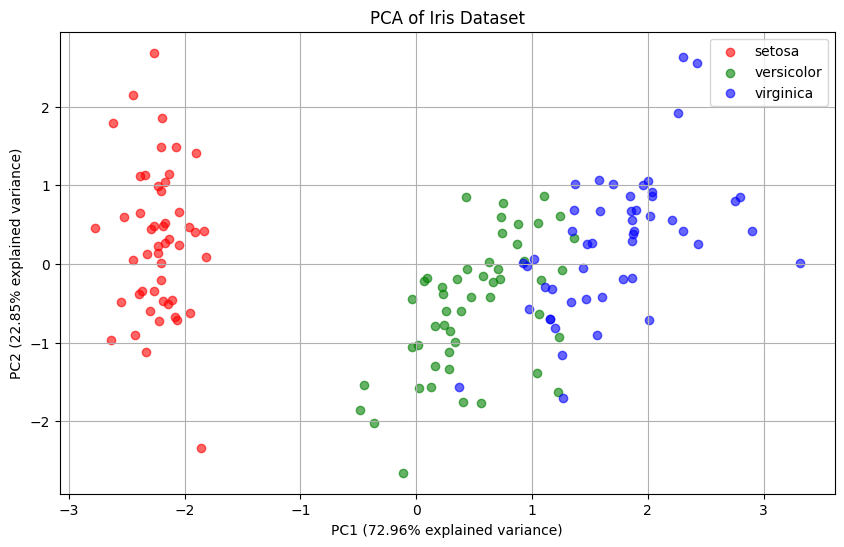

In [35]:
# Visualize data in 2D using the first two principal components
plt.figure(figsize=(10, 6))
colors = {0: 'red', 1: 'green', 2: 'blue'}
targets = [0, 1, 2]
target_names = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}

for target in targets:
    plt.scatter(X_pca[y == target, 0], X_pca[y == target, 1], 
                color=colors[target], alpha=0.6, label=target_names[target])

plt.title('PCA of Iris Dataset')
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} explained variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} explained variance)')
plt.legend()
plt.grid(True)
plt.show()

## 4. Interpreting Principal Components

The principal components can be interpreted by looking at the loadings (coefficients) of the original features.

In [36]:
# Get the loadings (coefficients) of each feature for each principal component
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=feature_names
)

loadings

,PC1,PC2,PC3,PC4
sepal length (cm),0.521066,0.377418,0.719566,-0.261286
sepal width (cm),-0.269347,0.923296,-0.244382,0.123510
petal length (cm),0.580413,0.024492,-0.142126,0.801449
petal width (cm),0.564857,0.066942,-0.634273,-0.523597


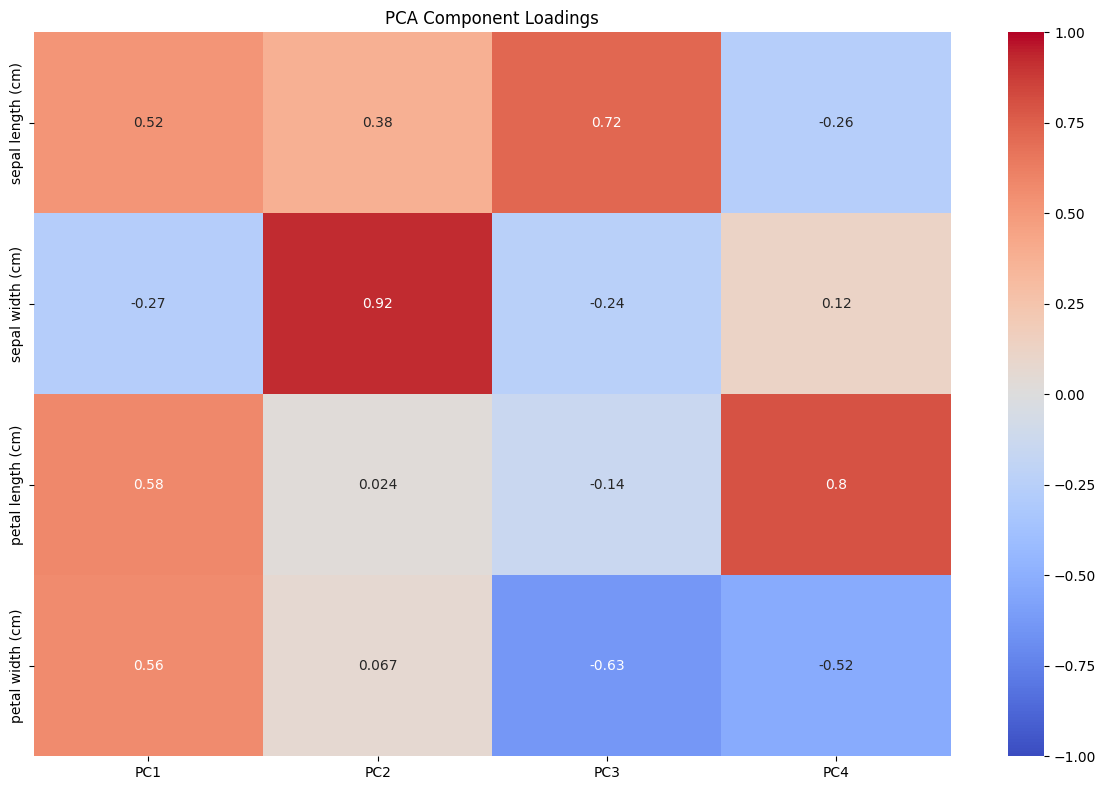

In [37]:
# Visualize the loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('PCA Component Loadings')
plt.tight_layout()
plt.show()

## 5. Practical Application: Dimensionality Reduction

Now let's use PCA for dimensionality reduction by keeping only the components that explain most of the variance.

In [39]:
# Reduce dimensions to 2 components
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_std)

# Create a DataFrame with the reduced data
reduced_df = pd.DataFrame(
    X_reduced,
    columns=['PC1', 'PC2']
)
reduced_df['species'] = df['species']

# Display the first few rows
reduced_df.head()

,PC1,PC2,species
0,-2.264703,0.480027,setosa
1,-2.080961,-0.674134,setosa
2,-2.364229,-0.341908,setosa
3,-2.299384,-0.597395,setosa
4,-2.389842,0.646835,setosa


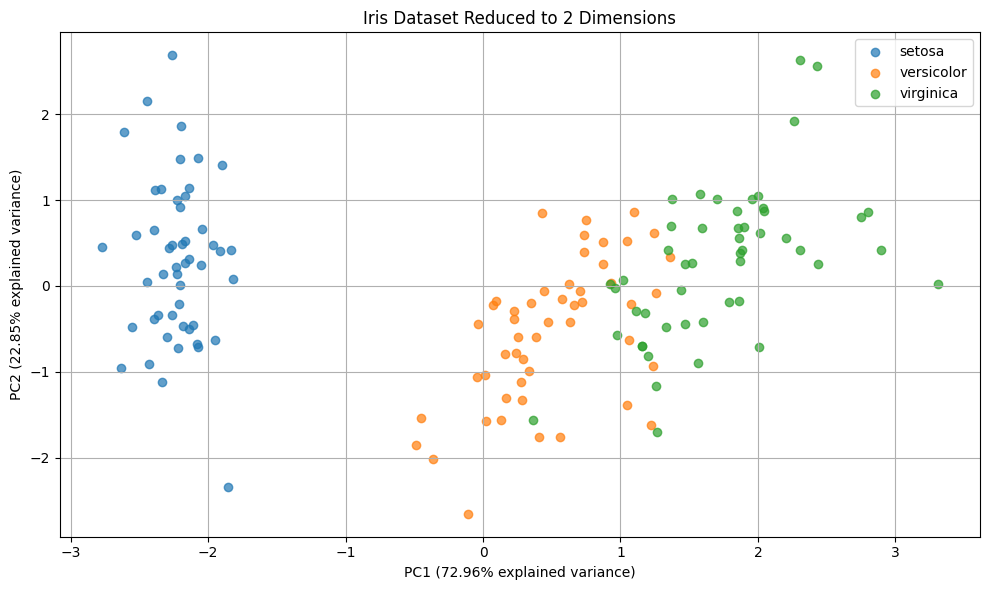

In [40]:
# Visualize the reduced data
plt.figure(figsize=(10, 6))
for species in reduced_df['species'].unique():
    subset = reduced_df[reduced_df['species'] == species]
    plt.scatter(subset['PC1'], subset['PC2'], label=species, alpha=0.7)

plt.title('Iris Dataset Reduced to 2 Dimensions')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Common Applications and Conclusion

### Applications of PCA:
- **Preprocessing for ML algorithms**: Reduce dimensions before applying ML algorithms
- **Image compression**: Representing images with fewer dimensions
- **Finance**: Analyzing stock market data and risk management
- **Genetics**: Analyzing gene expression data
- **Anomaly detection**: Identifying outliers in complex datasets

### Limitations of PCA:
- Only captures linear relationships between variables
- Sensitive to scaling of the original variables
- Principal components can be difficult to interpret
- May not work well with categorical data

### Alternatives to PCA:
- **t-SNE**: Better for visualization of high-dimensional data
- **UMAP**: Faster than t-SNE with better preservation of global structure
- **Kernel PCA**: For non-linear dimensionality reduction
- **Autoencoders**: Neural network-based approach for dimensionality reduction



## 7. Exercise (Optional if time permits)

Try applying PCA to another dataset, such as the wine dataset from scikit-learn.

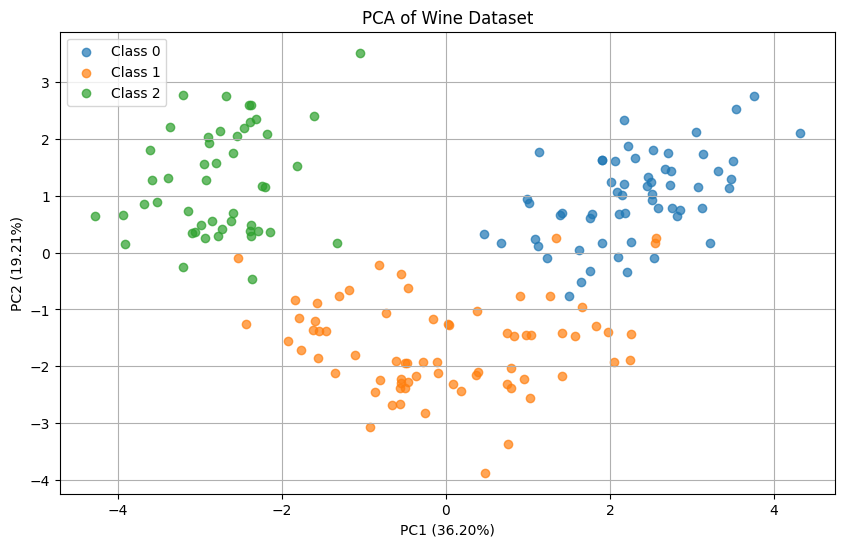

Explained variance ratio: [0.36198848 0.1920749 ]
Cumulative explained variance: [0.36198848 0.55406338]


In [41]:
from sklearn.datasets import load_wine

# Load the wine dataset
wine = load_wine()
X_wine = wine.data
y_wine = wine.target
feature_names_wine = wine.feature_names

# Standardize the data
X_wine_std = StandardScaler().fit_transform(X_wine)

# Apply PCA
pca_wine = PCA(n_components=2)
X_wine_pca = pca_wine.fit_transform(X_wine_std)

# Visualize the results
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.scatter(X_wine_pca[y_wine == i, 0], X_wine_pca[y_wine == i, 1], alpha=0.7, label=f'Class {i}')

plt.title('PCA of Wine Dataset')
plt.xlabel(f'PC1 ({pca_wine.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca_wine.explained_variance_ratio_[1]:.2%})')
plt.legend()
plt.grid(True)
plt.show()

# Print explained variance
print(f"Explained variance ratio: {pca_wine.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.cumsum(pca_wine.explained_variance_ratio_)[:2]}")